In [36]:
import os
import numpy as np
from imageio.v2 import imread, imwrite
from scipy.ndimage import sobel
from skimage.transform import resize
import matplotlib.pyplot as plt
from pathlib import Path

In [37]:
np.set_printoptions(suppress=True, linewidth=120)

def to_float01(img):
    img = img.astype(np.float32)
    mx = img.max() if img.size > 0 else 1.0
    if mx > 1.5:
        img /= mx
    return img

def crop_inner(img, frac=0.2):
    h, w = img.shape[:2]
    dh, dw = int(h * frac), int(w * frac)
    return img[dh:h-dh, dw:w-dw]
    

In [38]:
def split_bgr_plate(plate_gray):
    h = plate_gray.shape[0] // 3
    B = plate_gray[0:h, :]
    G = plate_gray[h:2*h, :]
    R = plate_gray[2*h:3*h, :]
    return B, G, R

In [39]:
def ncc(a, b):
    a = a - a.mean()
    b = b - b.mean()
    denominator = (np.linalg.norm(a) * np.linalg.norm(b) + 1e-8)
    return float((a * b).sum() / denominator)

def ssd(a, b):
    return float(((a - b) ** 2).sum())

def sobel_mag(img):
    gx = sobel(img, axis=1)
    gy = sobel(img, axis=0)
    return np.hypot(gx, gy)

In [40]:
def single_scale_align(base, target, radius=15, metric='ncc', use_grad=False, eval_crop=0.10):
    A = sobel_mag(base) if use_grad else base
    T = sobel_mag(target) if use_grad else target
    A_c = crop_inner(A, eval_crop)

    best_shift = (0, 0)
    best_score = -np.inf if metric == 'ncc' else np.inf

    for dy in range(-radius, radius + 1):
        for dx in range(-radius, radius + 1):
            T_shift = np.roll(np.roll(T, dy, axis=0), dx, axis=1)
            T_c = crop_inner(T_shift, eval_crop)
            if T_c.shape != A_c.shape:
                h = min(T_c.shape[0], A_c.shape[0])
                w = min(T_c.shape[1], A_c.shape[1])
                Tt = T_c[:h, :w]
                At = A_c[:h, :w]
            else:
                At = A_c
                Tt = T_c

            score = ncc(At, Tt) if metric == 'ncc' else ssd(At, Tt)

            if ((score > best_score) if metric == 'ncc' else (score < best_score)):
                best_score = score
                best_shift = (dy, dx)

    return best_shift
    

In [41]:
def build_pyramid(img, levels=5):
    img = img.astype(np.float32)
    pyr = [img]
    for _ in range(levels - 1):
        h, w = img.shape[:2]
        img = resize(
            img,
            (max(1, h // 2), max(1, w // 2)),
            anti_aliasing=True,
            preserve_range=True
        ).astype(np.float32)
        pyr.append(img)
    return pyr[::-1]

def align_pyramid(base, target, levels=5, coarse_radius=15, fine_radius=5, metric='ncc', use_grad=False, eval_crop=0.10):
    base_pyr = build_pyramid(base, levels)
    target_pyr = build_pyramid(target, levels)

    dy, dx = 0, 0
    for i in range(levels):
        b = base_pyr[i]
        t = np.roll(np.roll(target_pyr[i], dy, axis=0), dx, axis=1)
        radius = coarse_radius if i == 0 else fine_radius
        dyi, dxi = single_scale_align(b, t, radius, metric, use_grad, eval_crop)
        dy, dx = dy + dyi, dx + dxi
        if i < levels - 1:
            dy, dx = dy * 2, dx * 2

    return (dy, dx)

In [42]:
def postprocess_rgb(rgb, clip_percentiles=(1, 99)):
    out = rgb.copy()
    p_low, p_high = clip_percentiles
    for c in range(3):
        lo, hi = np.percentile(out[:, :, c], (p_low, p_high))
        out[..., c] = np.clip((out[..., c] - lo) / (hi - lo), 0, 1)
    return out
    

In [43]:
def colorize(path_in, path_out, use_pyramid=True, levels=5, metric='ncc', use_grad_for_hard_cases=True, eval_crop=0.10, coarse_radius=15, fine_radius=3, crop_final=0.05):
    plate = to_float01(imread(path_in))

    if plate.ndim == 3:
        plate = plate[..., 0]
    
    B, G, R = split_bgr_plate(plate)

    if use_pyramid:
        gy, gx = align_pyramid(B, G, levels, coarse_radius, fine_radius, metric, use_grad_for_hard_cases, eval_crop)
        ry, rx = align_pyramid(B, R, levels, coarse_radius, fine_radius, metric, use_grad_for_hard_cases, eval_crop)
    else:
        gy, gx = single_scale_align(B, G, radius=coarse_radius, metric=metric,
                            use_grad=use_grad_for_hard_cases, eval_crop=eval_crop)
        ry, rx = single_scale_align(B, R, radius=coarse_radius, metric=metric,
                            use_grad=use_grad_for_hard_cases, eval_crop=eval_crop)

    G_aligned = np.roll(np.roll(G, gy, axis=0), gx, axis=1)
    R_aligned = np.roll(np.roll(R, ry, axis=0), rx, axis=1)

    rbg = np.dstack([R_aligned, G_aligned, B])
    rgb = postprocess_rgb(rbg)

    if crop_final > 0:
        rgb = crop_inner(rgb, frac=crop_final)

    img_to_save = (np.clip(rgb, 0, 1) * 255).astype(np.uint8)
    imwrite(path_out, (np.clip(rgb, 0, 1) * 255).astype(np.uint8))

    print(f"G aligned by (dy, dx) = ({gy}, {gx})")
    print(f"R aligned by (dy, dx) = ({ry}, {rx})")
    return (gy, gx), (ry, rx)


G aligned by (dy, dx) = (5, 2)
R aligned by (dy, dx) = (12, 3)
G aligned by (dy, dx) = (-3, 2)
R aligned by (dy, dx) = (3, 2)
G aligned by (dy, dx) = (3, 3)
R aligned by (dy, dx) = (6, 3)


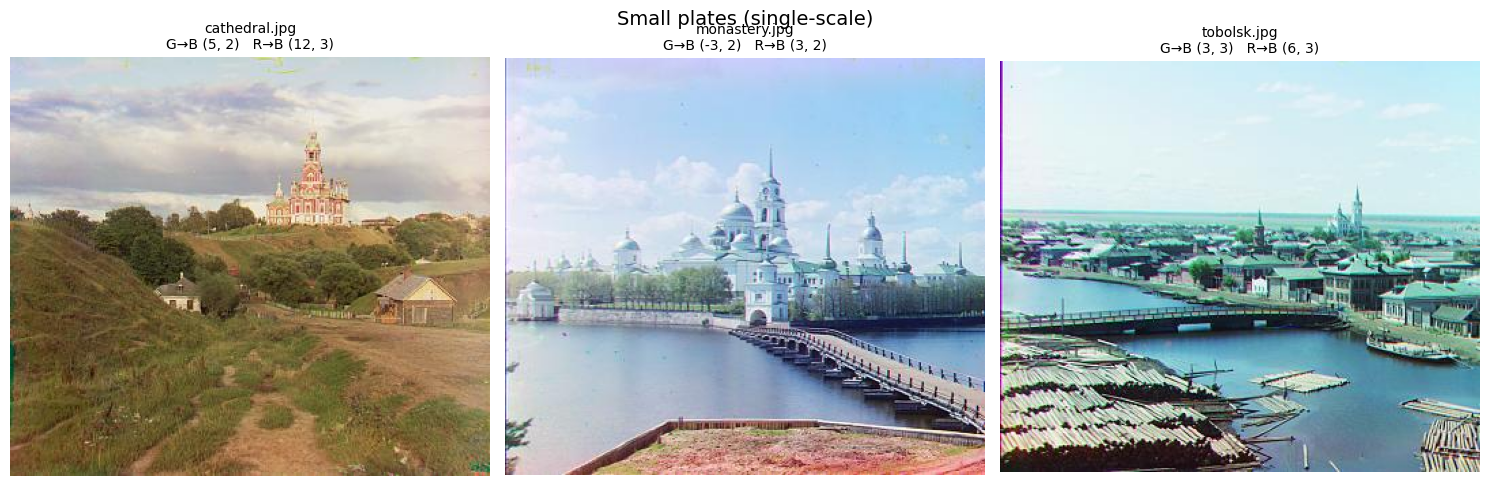

G aligned by (dy, dx) = (49, 24)
R aligned by (dy, dx) = (107, 40)
G aligned by (dy, dx) = (60, 17)
R aligned by (dy, dx) = (124, 14)
G aligned by (dy, dx) = (42, 17)
R aligned by (dy, dx) = (90, 23)


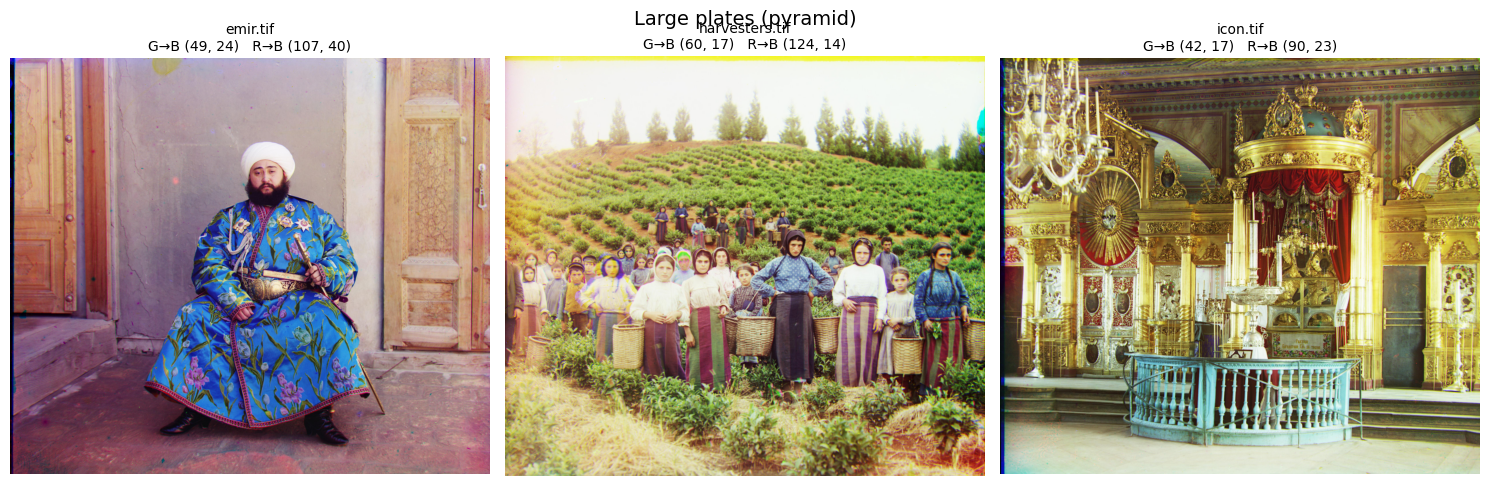

In [44]:
base = Path("../cs180_proj1_data/")     
out_dir = base / "results"
out_dir.mkdir(exist_ok=True)

def run_and_show(files, use_pyramid, levels, title, metric='ssd', use_grad=True):
    """Run colorize on 'files' and show a row of results with offsets."""
    fig, axes = plt.subplots(1, len(files), figsize=(5*len(files), 5))
    if len(files) == 1:
        axes = [axes]

    for ax, fname in zip(axes, files):
        inp = base / fname
        out = out_dir / (Path(fname).stem + "_color.jpg")

        G_off, R_off = colorize(
            str(inp), str(out),
            use_pyramid=use_pyramid,
            levels=levels,
            metric=metric,
            use_grad_for_hard_cases=use_grad,
            eval_crop=0.10,
            coarse_radius=15,
            fine_radius=3,
        )

        img = imread(out)
        ax.imshow(img)
        ax.set_title(f"{Path(fname).name}\nG→B {G_off}   R→B {R_off}", fontsize=10)
        ax.axis("off")

    fig.suptitle(title, fontsize=14)
    plt.tight_layout()
    plt.show()

small = ["cathedral.jpg", "monastery.jpg", "tobolsk.jpg"]
run_and_show(small, use_pyramid=False, levels=1, title="Small plates (single-scale)")

large = ["emir.tif", "harvesters.tif", "icon.tif"]
run_and_show(large, use_pyramid=True, levels=5, title="Large plates (pyramid)", use_grad=True)


In [48]:
import glob

data_dir = Path("../cs180_proj1_data/")
results_dir = Path("../results")
results_dir.mkdir(exist_ok=True)

image_files = []
for ext in ["*.jpg", "*.tif"]:
    image_files.extend(glob.glob(str(data_dir / ext)))

image_files.sort()

for img_path in image_files:
    img_name = Path(img_path).name
    output_path = results_dir / f"{img_name}_colorized.jpg"
    
    print(f"Processing {img_name}...")

    if img_path.endswith(".jpg"):
        use_pyramid = False
        levels = 1
    else:
        use_pyramid = True
        levels = 5
    
    g_off, r_off = colorize(
        path_in=img_path,
        path_out=output_path,
        use_pyramid=use_pyramid,
        levels=levels,
        metric='ssd',
        use_grad_for_hard_cases=True,
        eval_crop=0.10,
        coarse_radius=15,
        fine_radius=3
    )

    print(f"image {img_name} colorized and saved to {output_path} with offsets G→B {g_off} R→B {r_off}")

Processing cathedral.jpg...
G aligned by (dy, dx) = (5, 2)
R aligned by (dy, dx) = (12, 3)
image cathedral.jpg colorized and saved to ../results/cathedral.jpg_colorized.jpg with offsets G→B (5, 2) R→B (12, 3)
Processing church.tif...
G aligned by (dy, dx) = (25, 4)
R aligned by (dy, dx) = (58, -4)
image church.tif colorized and saved to ../results/church.tif_colorized.jpg with offsets G→B (25, 4) R→B (58, -4)
Processing cove.tif...
G aligned by (dy, dx) = (22, -17)
R aligned by (dy, dx) = (100, -33)
image cove.tif colorized and saved to ../results/cove.tif_colorized.jpg with offsets G→B (22, -17) R→B (100, -33)
Processing emir.tif...
G aligned by (dy, dx) = (49, 24)
R aligned by (dy, dx) = (107, 40)
image emir.tif colorized and saved to ../results/emir.tif_colorized.jpg with offsets G→B (49, 24) R→B (107, 40)
Processing harvesters.tif...
G aligned by (dy, dx) = (60, 17)
R aligned by (dy, dx) = (124, 14)
image harvesters.tif colorized and saved to ../results/harvesters.tif_colorized.jpg